In [1]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[WindowsPath('C:/Users/sepolt/.fastai/data/mnist_png/testing'),
 WindowsPath('C:/Users/sepolt/.fastai/data/mnist_png/training')]

In [10]:
# Pillow convert mode 'L' turns it to the gray scale mode. 
il = ImageList.from_folder(path, convert_mode='L')

In [11]:
il.items[0]

WindowsPath('C:/Users/sepolt/.fastai/data/mnist_png/testing/0/10.png')

In [8]:
# switch to default calor map to gray scale image rather than RGB
defaults.cmap = 'binary'

In [13]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\sepolt\.fastai\data\mnist_png

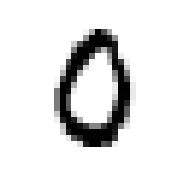

In [16]:
il[1].show()

In [17]:
sd = il.split_by_folder(train='training', valid='testing')

In [18]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\sepolt\.fastai\data\mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: C:\Users\sepolt\.fastai\data\mnist_png;

Test: None

In [19]:
ll = sd.label_from_folder()

In [20]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\sepolt\.fastai\data\mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: C:\Users\sepolt\.fastai\data\mnist_png;

Test: None

In [22]:
x, y = ll.train[0]

0torch.Size([1, 28, 28])


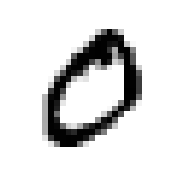

In [23]:
x.show()
print(y, x.shape)

In [25]:
# the second list refers to the validation set transforms so in this case there is no transforms
# for the validation set
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [26]:
ll = ll.transform(tfms)

In [27]:
bs = 128

In [28]:
# we will train from scratch therefore we will not use imagenet stats
# However, we will normalize data by taking a batch and extracting the mean and std from it
data = ll.databunch(bs=bs).normalize()

In [30]:
x,y = data.train_ds[0]

0


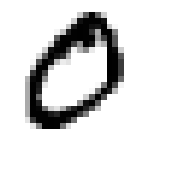

In [31]:
x.show()
print(y)

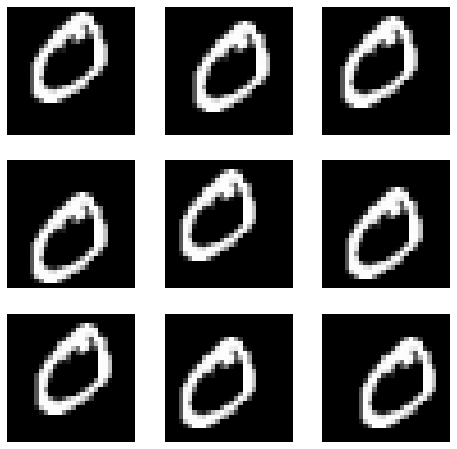

In [34]:
def _plot(i, j, ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [35]:
xb, yb = data.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

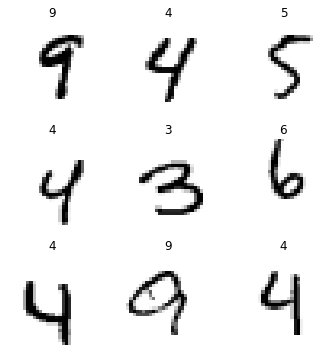

In [36]:
data.show_batch(rows=3, figsize=(5,5))

In [37]:
def conv(ni, no): return nn.Conv2d(ni, no, kernel_size=3, stride=2, padding=1)

In [38]:
model = nn.Sequential(
    conv(1, 8), #14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), #7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), #4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), #2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), #1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [41]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [42]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [43]:
xb = xb.cuda()

In [44]:
model(xb).shape

torch.Size([128, 10])

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


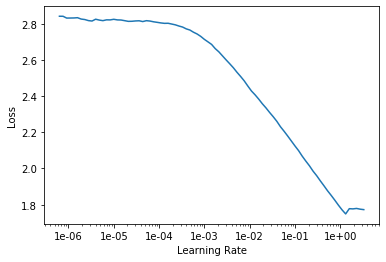

In [47]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.210750,0.217110,0.929400,01:54
1,0.137988,0.069187,0.977900,01:46
2,0.074157,0.043546,0.985300,01:37


# Refactor

In [50]:
def conv2d(ni, no): return conv_layer(ni, no, stride=2) 

In [51]:
model = nn.Sequential(
    conv2d(1, 8),
    conv2d(8, 16),
    conv2d(16, 32),
    conv2d(32, 16),
    conv2d(16, 10),
    Flatten()
)

In [52]:
learn = Learner(data, model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)

In [53]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.230479,0.164001,0.944500,01:38
1,0.184421,0.152322,0.954400,01:35
2,0.164357,0.201788,0.932700,01:41
3,0.135498,0.076637,0.976500,01:27
4,0.117073,0.150671,0.948800,01:27
5,0.100784,0.106704,0.965700,01:37
6,0.080287,0.040670,0.986400,01:44
7,0.061052,0.037214,0.988300,02:08
8,0.048707,0.028284,0.990700,02:06
9,0.042855,0.025990,0.991300,02:11


In [54]:
learn.save('CNN')

# ResNet-ish

In [55]:
class ResNetBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf, nf)
        self.conv2 = conv_layer(nf, nf)
    
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

In [56]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [57]:
model = nn.Sequential(
    conv2d(1, 8),
    res_block(8),
    conv2d(8, 16),
    res_block(16),
    conv2d(16, 32),
    res_block(32),
    conv2d(32, 16),
    res_block(16),
    conv2d(16, 10),
    Flatten()
)

In [58]:
def conv_and_res(ni, no): return nn.Sequential(conv2d(ni, no), res_block(no))

In [61]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2d(16, 10),
    Flatten()
)

In [62]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


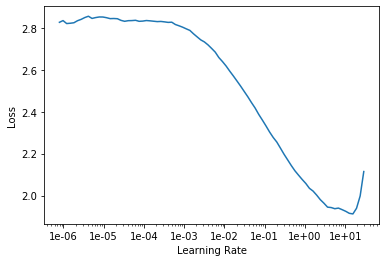

In [63]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [64]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.209456,0.124661,0.965600,01:58
1,0.116083,0.113058,0.967100,01:36
2,0.092988,0.249103,0.925800,01:31
3,0.090899,0.054962,0.983700,01:31
4,0.063633,0.072160,0.976100,01:31
5,0.059873,0.081147,0.974200,01:30
6,0.056874,0.042753,0.986400,01:30
7,0.046533,0.035091,0.989200,01:31
8,0.035360,0.024339,0.992700,01:30
9,0.023894,0.016130,0.994900,01:30


In [65]:
learn.save("resnetish")